In [1]:
from __future__ import print_function, division

import torchvision
import torchvision.transforms.v2
from torchvision import models
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import pandas as pd

## Dataset

In [2]:
# found this in: https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py
class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        overlaps = self._get_overlaps()
        if overlaps is not None:
            images['image_name'] = images['filepath'].str.split("/").str[-1]
            overlaps = overlaps.merge(images, left_on='cub_name', right_on='image_name')
            overlaps['is_training_img'] = 1
            train_test_split.update(overlaps)


        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def _get_overlaps(self):
        try:
            download_url('https://gist.githubusercontent.com/arunmallya/a6889f151483dcb348fa70523cb4f578/raw/1ae0992b71375f63bd3779ac41eff4455918a6a8/matches.txt',
                         root=self.root,
                         filename='overlaps.txt')
            return pd.read_csv(os.path.join(self.root, 'overlaps.txt'),
                                    sep=' -> ', names=['cub_name', 'imagenet_name'])
        except Exception:
            return None




    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
base_transform = models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()

data_transforms = {
    'train': torchvision.transforms.v2.Compose([
        torchvision.transforms.v2.ToTensor(),
        torchvision.transforms.v2.RandomResize(min_size=base_transform.crop_size[0], max_size=base_transform.crop_size[0]+32, antialias=True),
        torchvision.transforms.v2.RandomHorizontalFlip(),
        torchvision.transforms.v2.RandomRotation(degrees=(-10, 10)),
        torchvision.transforms.v2.RandomPerspective(distortion_scale=0.2),
        torchvision.transforms.v2.CenterCrop(size=base_transform.crop_size),
        torchvision.transforms.v2.RandomErasing(scale=(0.02, 0.1)),
        torchvision.transforms.v2.RandomErasing(scale=(0.02, 0.1)),
        torchvision.transforms.v2.Normalize(mean=base_transform.mean, std=base_transform.std),
    ]),
    'test': base_transform,
}

data_sets = {
    x: Cub2011(os.path.abspath("./data"), train=x=='train', transform=data_transforms[x] ) for x in ['train', 'test']
}

data_loaders = {
    'train': DataLoader(data_sets['train'], batch_size=20, shuffle=True),
    'test': DataLoader(data_sets['test']),
}

dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'test']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


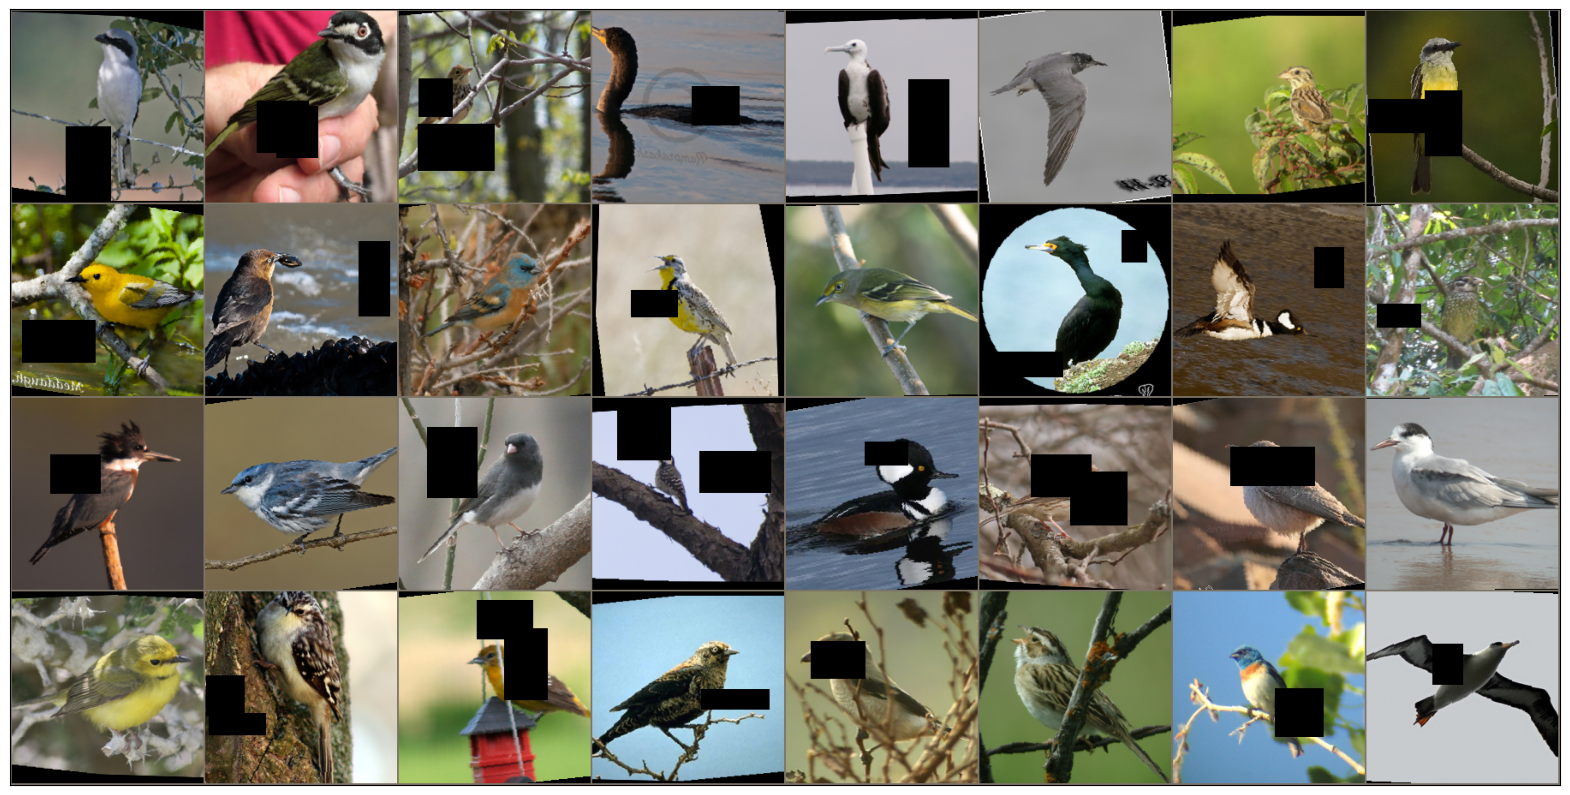

In [4]:
sample = torchvision.utils.make_grid(next(iter(DataLoader(data_sets['train'], batch_size=32, shuffle=True)))[0])
sample = sample.numpy().transpose((1, 2, 0))
#undo normalization
sample = base_transform.std * sample + base_transform.mean
plt.figure(figsize=(20, 16))
fig = plt.imshow(sample)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

## Model

In [5]:
def reset_parameters(module: nn.Module):
    if hasattr(module, 'reset_parameters') and callable(module.reset_parameters):
        module.reset_parameters()

model = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 200)
model.classifier.apply(reset_parameters)  # by default parameters in Classifier are set to Nan, we need to initialize it

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=200, bias=True)
)

In [6]:

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Training

In [7]:
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def examine_lr_range(model, criterion, get_optimizer, data_loader, low_log, up_log):
    original_model = copy.deepcopy(model.state_dict())
    model.train()

    lr_range = np.logspace(low_log, up_log, len(data_loader))
    
    lr_list = []
    train_loss_history = []

    # Iterate over data.
    for lr, data in zip(lr_range, data_loader):
        X = data[0].to(device)
        y = data[1].to(device)

        # zero the parameter gradients
        optimizer = get_optimizer(model, lr)

        # forward
        # track history only if in train
        with torch.set_grad_enabled(True):
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        lr_list.append(lr)
        train_loss_history.append(loss.item())
    
    model.load_state_dict(original_model)
    
    return lr_list, train_loss_history

In [10]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
criterion = nn.CrossEntropyLoss()

def get_optimizer(model, lr):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    return optim.SGD(parameters, lr, weight_decay=0.0)

lrs, losses = examine_lr_range(model, criterion, get_optimizer, data_loaders["train"], low_log=-6, up_log=-1)
plt.plot(lrs, losses)
plt.xscale('log')
plt.show()

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=7)

In [15]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

## Save model